In [1]:
"Displaying the difference between Sigmoid and ReLU nonlinearlties in a simple 2 hidden layer network"
#setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0) #set plot default size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Auto re-load extrenal modules
%load_ext autoreload
%autoreload 2


(-1.0, 1.0)

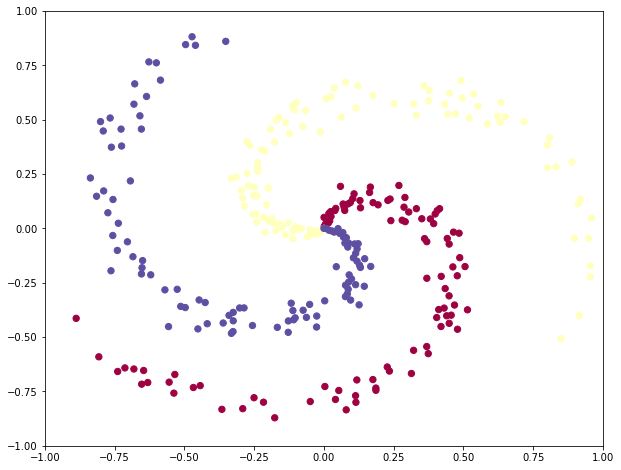

In [8]:
#generate random data -- not linearly separable
np.random.seed(0)
N = 100 #number of points per class
D = 2 #dimenstionality
K = 3 #number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K,dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) #radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 #theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
    

In [9]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0,x)


In [11]:
"""function to train a three layer neural net with either RELU or Sigmoid via Vanilla gradien decent"""

def three_layer_net(NONLINEARITY, X, y, model, step_size, reg):
    #parameter initialization
    #some hyperparameters
    h = model['h']
    h2 = model['h2']
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    
    #gradient decent loop
    num_examples = X.shape[0]
    plot_array_1 = [] 
    plot_array_2 = []
    for i in range(50000):
        
        #FORWARD PROP
        if NONLINEARITY == 'RELU':
            hidden_layer1 = relu(np.dot(X,W1)+b1)
            hidden_layer2 = relu(np.dot(hidden_layer1,W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
            
        elif NONLINEARITY == 'SIGM':
            hidden_layer1 = sigmoid(np.dot(X,W1)+b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer1,W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
            
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #(N x K)
        
        #compute the loss: average cross entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print("iteration %d: loss %f"%(i,loss))
            
        
        #compute the gradient on scores
        dscores = probs
        dscores[range(num_examples,y)] -= 1
        dscores /= num_examples
        
        #BACKPROP 
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims = True)
        
        if NONLINEARITY == 'RELU':
            #Relu backpropagation
            dhidden2 = np.dot(dscores,W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidde_layer1.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis =0)
            dhidden1 = np.dot(dhidden2, W2.T)
            dhidden1[hidden_layer1 <= 0] = 0
            
        elif NONLINEARITY == 'SIGM':
            #sigmoid backpropaation
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 =! (hidden_layer1.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis =0)
            dhidden1 = np.dot(dhidden2, W2.T)*sigmoid_grad(hidden_layer1)
            
        dW1 = np.dot(X.T, dhidden1)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden1, axis=0)
        
        #add regularization
        dW3 += reg*W3
        dW2 += reg*W2
        dW1 += reg*W1
        
        #option to return loss, grads 
        grads = {}
        grads['W1'] = dW1
        grads['W2'] = dW2
        grads['W3'] = dW3
        grads['b1'] = db1
        grads['b2'] = db2
        grads['b3'] = db3
        
        #update parameters
        W1 += -(step_size * dW1)
        W2 += -(step_size * dW2)
        W3 += -(step_size * dW3)
        b1 += -(step_size * db1)
        b2 += -(step_size * db2)
        b3 += -(step_size * db3)
    
    #evaluate training net accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer1 = relu(np.dot(X,W1)+b1)
        hidden_layer2 = relu(np.dot(hidden_layer1,W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer1 = sigmoid(np.dot(X,W1)+b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer1,W2) + b2)
    
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis = 1)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
    
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

In [15]:
#initlize toy model, train sigmoid net

N = 100
D = 2
K = 3
h = 50
h2 = 50
num_trian_examples = X.shape[0]

model ={}
model['h'] = h #size of hidden layer 1
model['h2'] = h2 #size of hidden layer 2
model['W1'] = 0.1*np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1*np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1*np.random.randn(h2,K)
model['b2'] = np.zeros((1,K))

sigm_array_1, sigm_array_2, s_W1, s_W2, s_W3, s_b1, s_b2, s_b3 = three_layer_net('SIGM', X, y, model, 0.001, reg)

NameError: name 'reg' is not defined

In [16]:
#re-initlize toy model, train sigmoid net

model ={}
model['h'] = h #size of hidden layer 1
model['h2'] = h2 #size of hidden layer 2
model['W1'] = 0.1*np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1*np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1*np.random.randn(h2,K)
model['b2'] = np.zeros((1,K))

relu_array_1, relu_array_2, r_W1, r_W2, r_W3, r_b1, r_b2, r_b3 = three_layer_net('RELU', X, y, model, 0.001, reg)

NameError: name 'reg' is not defined

In [17]:
"""Vanishing Gradient issue"""
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigma first layer", "sigm second layer"))

NameError: name 'sigm_array_1' is not defined

In [19]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- RELU weights')
plt.legend(("relu first layer", "relu second layer"))

NameError: name 'relu_array_1' is not defined